# Stereoisomer testing on ChiENN - skelettisomere

## Importing section

In [17]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import sys

sys.path.append("../../../../")

from ptgnn.features.chienn.mol_to_data import mol_to_data
from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
from ptgnn.transform import edge_graph_transform

## Define SMILES strings

In [18]:
smiles_list = [
    "CCCCCC",
    "CCCC(C)C",
    "CCC(C)CC",
    "CC(C)C(C)C",
    "CCC(C)(C)C",
]

## Visualize and confirm stereomer classification (E/Z)

In [19]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

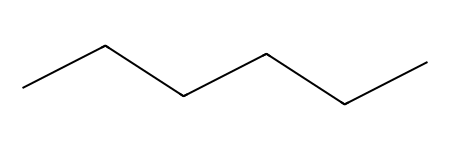

[]


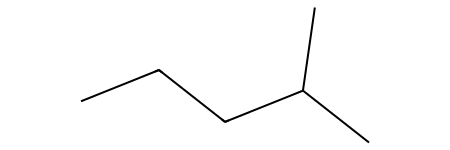

[]


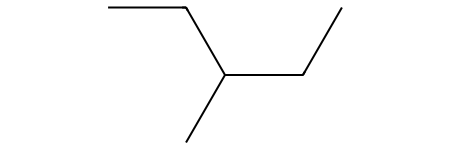

[]


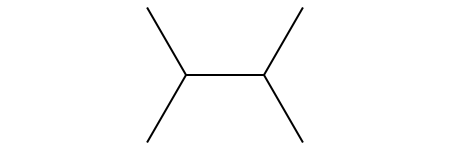

[]


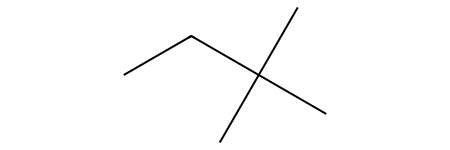

[]


In [20]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph with ptree

In [21]:
# get molecules
mol_list = [
    smiles_to_3d_mol(
        smiles,
        max_number_of_attempts=100,
        max_number_of_atoms=100
    )
    for smiles in smiles_list
]

In [22]:
data_list = [
    mol_to_data(mol)
    for mol in mol_list
]

In [23]:
data_list = [
    edge_graph_transform(
        data,
        transformation_mode="permutation_tree",
        mol=mol,
        transformation_parameters={
            'k':  3,
            'tetrahedral_chiral': True,
            'chiral_center_selective': True,
            'chiral_center_select_potential': False,
        }
    )
    for data, mol in zip(data_list, mol_list)
]

In [24]:
for data in data_list:
    print(data)
    print(data.ptree)

Data(x=[38, 93], edge_index=[2, 110], edge_attr=[110, 57], pos=[38, 6], parallel_node_index=[38], circle_index=[38], ptree=[38], initial_map=[148], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=2, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1])
['{"S": [0, 1, {"P": [3, 5, 7]}]}', '{"S": [1, 0, {"P": [9, 13, 11]}]}', '{"S": [2, 3, {"P": [1, 7, 5]}]}', '{"S": [3, 2]}', '{"S": [4, 5, {"P": [1, 3, 7]}]}', '{"S": [5, 4]}', '{"S": [6, 7, {"P": [1, 5, 3]}]}', '{"S": [7, 6]}', '{"S": [8, 9, {"P": [0, 11, 13]}]}', '{"S": [9, 8, {"P": [15, 17, 19]}]}', '{"S": [10, 11, {"P": [0, 13, 9]}]}', '{"S": [11, 10]}', '{"S": [12, 13, {"P": [0, 9, 11]}]}', '{"S": [13, 12]}', '{"S": [14, 15, {"P": [8, 19, 17]}]}', '{"S": [15, 14, {"P": [21, 23, 25]}]}', '{"S": [16, 17, {"P": [8, 15, 19]}]}', '{"S": [17, 16]}', '{"S": [18, 19, {"P": [8, 17, 15]}]}', '{"S": [19, 18]}', '{"S": [20, 21, {"P": [14, 25, 23]}]}', '{"S": [21, 20, {"P": [27, 29, 31]}]}', '{"S": [22, 

## Create Model

In [25]:
import torch
from ptgnn.model.modules.custom_wrapper import CustomWrapper
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer

k = 3

modules_list = [
    CustomWrapper(AdvancedPermutationTreeLayer(
        hidden_dim=93,
        k=k,
        apply_p_elu=True
    ))
    for _ in range(1)
] + [
    AdvancedPermutationTreeLayer(
        hidden_dim=93,
        k=k,
        apply_p_elu=True
    )
]

model = torch.nn.Sequential(
    *modules_list
)
model

Sequential(
  (0): CustomWrapper(
    (layer_to_wrap): AdvancedPermutationTreeLayer(
      (p_layer): Linear(in_features=93, out_features=93, bias=False)
      (p_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (p_elu): ELU(alpha=1.0)
      (z_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (z_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (s_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (s_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (z2_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (z2_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (s2_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (s2_final_layer): Linear(in_features=93, out_features=93, bias=False)
     

## Create batches

In [26]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

In [27]:
# compare output
display(np.array(
    [
        [
            (batch_list[i].x == batch_list[j].x).all() if batch_list[i].x.shape == batch_list[j].x.shape else np.nan
            for j in range(len(batch_list))
        ]
        for i in range(len(batch_list))
    ]
))

array([[ True, False, False, False, False],
       [False,  True, False, False, False],
       [False, False,  True, False, False],
       [False, False, False,  True, False],
       [False, False, False, False,  True]])

## Put batches through model

In [28]:
out_list = [
    model(batch)
    for batch in batch_list
]

## Compare batches

In [29]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all() if out_list[i].shape==out_list[j].shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ True, False, False, False, False],
       [False,  True, False, False, False],
       [False, False,  True, False, False],
       [False, False, False,  True, False],
       [False, False, False, False,  True]])

In [30]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True, False, False, False, False],
       [False,  True, False, False, False],
       [False, False,  True, False, False],
       [False, False, False,  True, False],
       [False, False, False, False,  True]])

In [31]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 0.00000000e+00, -2.12895155e-01, -2.12377191e-01,
        -4.26108837e-01, -6.95519686e-01],
       [ 2.12895155e-01,  0.00000000e+00,  5.17964363e-04,
        -2.13213682e-01, -4.82624531e-01],
       [ 2.12377191e-01, -5.17964363e-04,  0.00000000e+00,
        -2.13731647e-01, -4.83142495e-01],
       [ 4.26108837e-01,  2.13213682e-01,  2.13731647e-01,
         0.00000000e+00, -2.69410849e-01],
       [ 6.95519686e-01,  4.82624531e-01,  4.83142495e-01,
         2.69410849e-01,  0.00000000e+00]])

In [32]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum() if batch_list[i].x.shape == batch_list[j].x.shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 0.      , 27.29722 , 27.89899 , 53.062805, 51.569794],
       [27.29722 ,  0.      , 50.256775, 28.86983 , 49.560204],
       [27.89899 , 50.256775,  0.      , 72.206406, 28.120415],
       [53.062805, 28.86983 , 72.206406,  0.      , 69.64395 ],
       [51.569794, 49.560204, 28.120415, 69.64395 ,  0.      ]],
      dtype=float32)

Distinguishes correctly